## Problem Statement & Objective
The objective of this notebook is to design a reusable and stock-agnostic analysis pipeline that helps understand a stock’s historical performance, risk characteristics, and behavior under stress.
The analysis focuses on interpretable financial metrics, ensuring applicability across different stocks and sectors.

## Data Source 
Historical stock price data is fetched from Yahoo Finance using the `yfinance` library.
This provides daily OHLC prices and trading volume, which are sufficient for
performance and risk analysis.

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")


In [10]:
def load_stock_data(ticker, start=None):
    df = yf.download(ticker, start=start, progress=False)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    return df

## Example Stock

To demonstrate the analysis pipeline, a single stock is used as an example.
The same analysis applies to any valid stock ticker.


In [11]:
ticker = "RELIANCE.NS"
df = load_stock_data(ticker, start="2019-01-01")
df.head()


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-01,498.490601,501.292148,493.643566,500.380542,9746670
2019-01-02,491.998230,501.158723,489.596917,495.600156,15628818
2019-01-03,485.928284,495.644616,484.749875,492.487362,16288287
2019-01-04,488.551941,491.131123,480.747753,487.996102,18516544
2019-01-07,491.264465,497.356638,489.596889,492.265005,12060290


## Price Trend Analysis

The closing price is used to observe the long-term direction of a stock.
While price trends indicate general movement, they do not capture risk
or return variability.


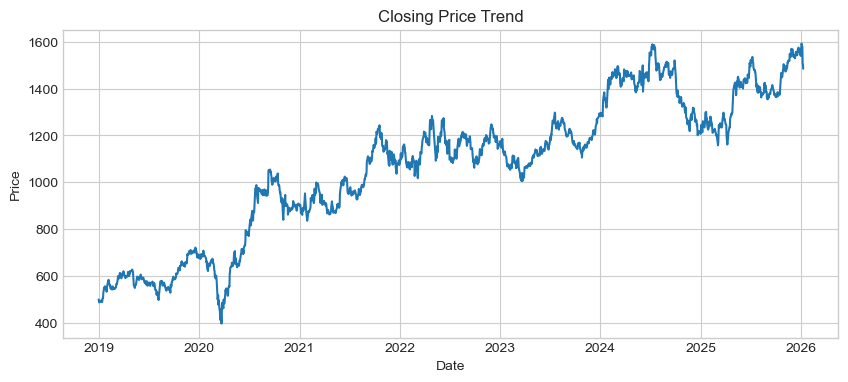

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"])
plt.title("Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

**Observation:**  
The closing price trend provides a high-level view of the stock’s long-term
direction. While it helps identify periods of growth, decline, or consolidation,
it does not reveal the magnitude of day-to-day fluctuations or the level of risk
involved. This limitation motivates the need for return-based analysis.


## Daily Returns

Daily returns measure the percentage change in price from one trading day to the next.
They help reveal **short-term variability** and sudden price movements that are not
visible in long-term price trends.

Analyzing daily returns is essential for understanding the **stability and risk**
associated with a stock.


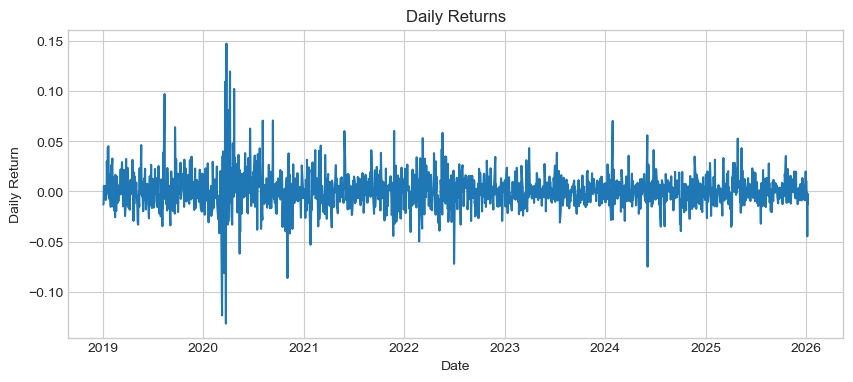

In [14]:
df["Daily_Return"] = df["Close"].pct_change()

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Daily_Return"])
plt.title("Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()

**Observation:**  
Daily returns are highly noisy and fluctuate around zero for most of the period,
indicating that short-term price movements are largely unpredictable. Occasional
extreme spikes highlight periods of elevated market stress, reinforcing the need
to analyze aggregated performance and risk metrics.


## Cumulative Returns

While daily returns highlight short-term fluctuations, they do not provide a clear
picture of how an investment grows over time. Cumulative returns address this by
compounding daily returns to show the growth of an initial investment.

This metric translates price movement into an **investment perspective**, making it
easier to assess long-term performance.


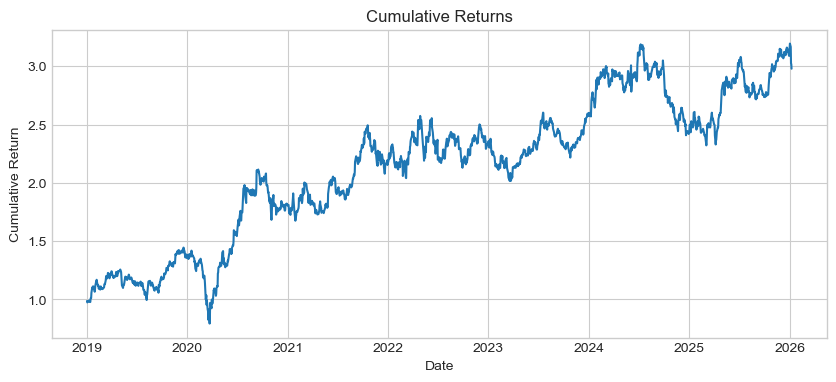

In [20]:
df["Cumulative_Return"] = (1 + df["Daily_Return"]).cumprod()

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Cumulative_Return"])
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()


**Observation:**  
Cumulative returns smooth out short-term noise and provide a clear view of long-term
performance. Sustained upward movement indicates consistent value creation over time,
while sharp declines reflect periods of significant drawdown. This metric is more
interpretable for long-term decision-making than raw price or daily returns alone.


## Volatility

Volatility measures of the degree of variation in a stock's returns over time.
It captures how **unstable or uncertain** price movements are, rather than
whether prices are moving up or down.

Higher volatility indicates larger and more frequent price swings, which
can increase uncertainty and emotional stress for investors.


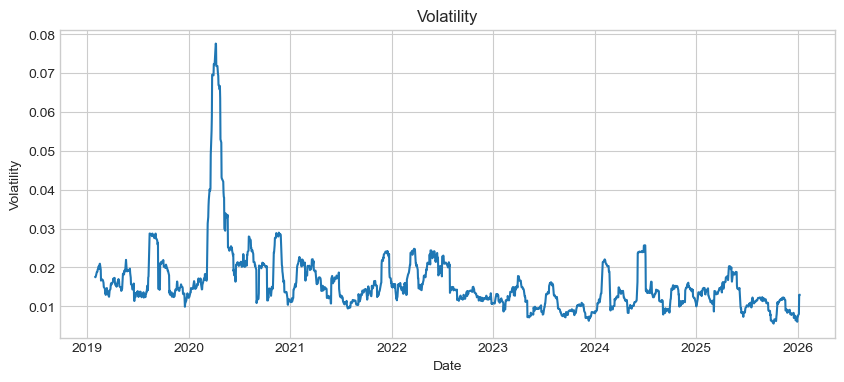

In [24]:
df["Volatility"] = df["Daily_Return"].rolling(window=20).std()

plt.figure(figsize=(10,4))
plt.plot(df.index , df["Volatility"])
plt.title("Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

**Observation:**  
Volatility is not constant over time and tends to cluster into periods of
high and low risk. Extended spikes in volatility indicate sustained uncertainty,
while lower volatility periods suggest more stable price behavior. This metric
helps assess the intensity of risk but does not quantify actual losses.


## Drawdown
 While volatility measures how unstable returns are, it does not capture the actual losses an investor might experience. Drawdown addresses this limitation by measuring the decline from a stock' previous peak to its subsequent trough.
Drawdown answers a critical question for decision making:
**How bad could it get at the worst possible time?**


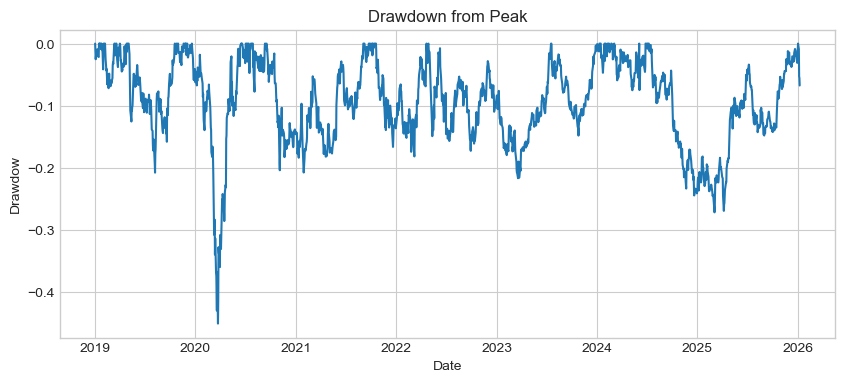

In [26]:
df["Rolling_Peak"] = df["Close"].cummax()
df["Drawdown"] = (df["Close"] - df["Rolling_Peak"])/df["Rolling_Peak"]

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Drawdown"])
plt.title("Drawdown from Peak")
plt.xlabel("Date")
plt.ylabel("Drawdow")
plt.show()

**Observation:**  
Drawdown highlights the magnitude and duration of worst-case losses. Deep drawdowns
indicate periods of severe stress where investors face significant declines from
previous highs. Unlike volatility, drawdown directly reflects potential financial
and psychological impact, making it a critical metric for risk-aware decision-making.


## Key Performance Indicators (KPI) Derivation

While time-series analysis helps understand how a stock behaves over time,
decision-making often requires **condensed summary metrics**.

In this section, key performance indicators (KPIs) are derived from the previously
analyzed metrics to provide a compact representation of performance and risk.


In [29]:
total_return = df["Cumulative_Return"].iloc[-1] - 1
annualized_volatility = df["Daily_Return"].std()*np.sqrt(252)
max_drawdown = df["Drawdown"].min()

latest_price = df["Close"].iloc[-1]
kpi_df = pd.DataFrame({
    "Metric": [
        "Latest Price",
        "Total Return(%)",
        "Annualized Volatility(%)",
        "Maximum Drawdown(%)"
    ],
    "Value": [
        round(latest_price, 1),
        round(total_return * 100, 1),
        round(annualized_volatility * 100, 1),
        round(max_drawdown * 100, 1)
    ]
})

kpi_df

,Metric,Value
0,Latest Price,1484.9
1,Total Return(%),197.9
2,Annualized Volatility(%),28.1
3,Maximum Drawdown(%),-45.1


## Decision-Relevant Interpretation

The analysis combines **time-series metrics** and **summary KPIs**, as each serves
a different purpose in decision-making.

Time-series metrics (price, returns, volatility, drawdown) show **how a stock
behaves over time**, revealing trends, instability, and stress periods.
KPIs condense this behavior into **interpretable numbers** such as total return,
annualized volatility, and maximum drawdown.

Together, metrics provide context while KPIs enable quick evaluation, allowing
users to assess performance and risk without relying on predictions.


## Pipeline Summary & Dashboard Design Rationale

This notebook defines a **generic stock analysis pipeline** applicable to any
ticker using historical data.

Time-series metrics are first analyzed to understand trend, performance, and risk.
From these metrics, key performance indicators (KPIs) are derived to summarize
reward and downside risk.

The dashboard applies this same pipeline dynamically to user-selected stocks,
using KPIs for quick assessment and prioritized visualizations to retain
historical context, functioning purely as a decision-support interface.
